In [1]:
import pandas as pd
import numpy as np
import os

import json
from pathlib import Path

os.chdir('/cluster/home/kruu/git/eye_tracking/')
# os.chdir('/home/kruu/git_folder/eye_tracking/')
from utils.data_processing import EyeTrackingProcessor

import torch
from torch.utils.data import DataLoader
from models.lstm_classifier import LSTMClassifier
from utils.train import train_classifier, split_by_participant, export_to_onnx
from utils.dataset import GazeMouseDataset

****
# Import Datasets
****

In [2]:
# data_path = "/store/kruu/eye_tracking"
data_path = "/cluster/home/kruu/store/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Event', 'Participant name']
interpolate_col = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Blink']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)
dataset, blinks = processor.detect_blinks(dataset)

# Fixed Time step resampling
dataset_time_resampled = processor.resample_tasks_fixed_time(dataset, interpolate_col, timestep = 0.01)
dataset_time_resampled.Blink = (dataset_time_resampled.Blink > 0.5) #Transform interpolated data
# dataset_time_resampled = processor.pad_tasks(dataset_time_resampled) # No need to pad here
dataset_time_resampled["id"] = dataset_time_resampled["Participant name"].astype(str) + "_" + dataset_time_resampled["Task_id"].astype(str) + "_" + dataset_time_resampled["Task_execution"].astype(str)

/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/cluster/home/kruu/git/eye_tracking/utils/data_processing.py:16: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


In [3]:
dataset_time_resampled["Mouse position X"] = dataset_time_resampled["Mouse position X"].ffill().bfill()
dataset_time_resampled["Mouse position Y"] = dataset_time_resampled["Mouse position Y"].ffill().bfill()
dataset_time_resampled["Gaze point X"] = dataset_time_resampled["Gaze point X"].ffill().bfill()
dataset_time_resampled["Gaze point Y"] = dataset_time_resampled["Gaze point Y"].ffill().bfill()

In [4]:
# add information about movements
dataset_time_resampled["Gaze X delta"] = dataset_time_resampled.groupby("id")["Gaze point X"].diff().fillna(0)
dataset_time_resampled["Gaze Y delta"] = dataset_time_resampled.groupby("id")["Gaze point Y"].diff().fillna(0)
dataset_time_resampled["Mouse X delta"] = dataset_time_resampled.groupby("id")["Mouse position X"].diff().fillna(0)
dataset_time_resampled["Mouse Y delta"] = dataset_time_resampled.groupby("id")["Mouse position Y"].diff().fillna(0)

****
# Classifier
****

In [5]:
features = ['Relative timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Gaze X delta', 'Gaze Y delta', 'Mouse X delta', 'Mouse Y delta','Blink']

input_dim = len(features)
hidden_dim = 128
num_classes = 6
num_layers = 1
batch_size = 32
lr = 0.001
num_epochs = 100

train_df, val_df, test_df = split_by_participant(dataset_time_resampled, val_split=0.2, test_split=0.1)
model = LSTMClassifier(input_dim, hidden_dim, num_classes, num_layers, lr)

model_trained, mean, std, best_ckpt_path = train_classifier(model,
                                    train_df,
                                    val_df,
                                    features,
                                    num_epochs=num_epochs,
                                    data_augment=False,
                                    use_wandb=True)

export_dir = Path(best_ckpt_path).parent.parent
onnx_path = os.path.join(export_dir,"best_lstm_classifier.onnx")

export_to_onnx(model = model_trained, 
               input_dim=input_dim, 
               export_path=onnx_path,
               sequence_len=10000)

metadata = {
    "features": features,
    "mean": {k: float(v) for k, v in mean.to_dict().items()},
    "std": {k: float(v) for k, v in std.to_dict().items()},
    "train_ids": train_df["id"].unique().tolist(),
    "val_ids": val_df["id"].unique().tolist(),
    "test_ids": test_df["id"].unique().tolist(),
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_classes": num_classes,
    "num_layers": num_layers,
    "batch_size": batch_size,
    "data_augmentation": False,
}

# Save to JSON
metadata_path = os.path.join(export_dir,"model_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {metadata_path}")

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /raid/persistent_scratch/kruu/venvs/aware/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kruu (zhaw_zav) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | val_accuracy   | MulticlassAccuracy | 0      | train
2 | tcn            | TCN                | 97.3 K | train
3 | lstm           | LSTM               | 264 K  | train
4 | dropout        | Dropout            | 0      | train
5 | fc             | Linear             | 1.5 K  | train
6 | criterion      | FocalLoss          | 0      | train
--------------------------------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.452     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eva

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, v_num=4a07, train_loss_step=0.200, val_loss=2.090, val_acc=0.278, train_loss_epoch=0.219, train_acc_epoch=0.938]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s, v_num=4a07, train_loss_step=0.200, val_loss=2.090, val_acc=0.278, train_loss_epoch=0.219, train_acc_epoch=0.938]
✅ Model exported to GazeMouse_Classification/ni0d4a07/best_lstm_classifier.onnx
✅ Metadata saved to GazeMouse_Classification/ni0d4a07/model_metadata.json


/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


****
# Analysis
****

WARNING: ONNX DOESN'T SUPPORT PACK_PADDED_SEQUENCE AND THUS MODIFIES THE TRAINING ARCHITECTURE DURING INFERENCE

## ONNX Model

In [ ]:
from utils.train import evaluate_onnx_model

metadata_path = '/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/yl6a73ww/model_metadata.json'
onnx_path = '/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/yl6a73ww/best_lstm_classifier.onnx'

with open(metadata_path, "r") as f:
    metadata = json.load(f)

onnx_res = evaluate_onnx_model(onnx_path, 
                          dataset_time_resampled.query(f"id in {metadata["train_ids"]}"),
                          metadata["features"],
                          metadata["mean"], 
                          metadata["std"])

/cluster/home/kruu/git/eye_tracking/utils/dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Relative timestamp'] = dataset.groupby('id')['Recording timestamp'].transform(lambda x: x - x.min())
/cluster/home/kruu/git/eye_tracking/utils/dataset.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[features] = (dataset[features] - self.mean) / self.std
2025-04-08 16:28:31.585649205 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 888849, index:

🧠 ONNX Evaluation: Loss = 1.6418, Accuracy = 0.4081


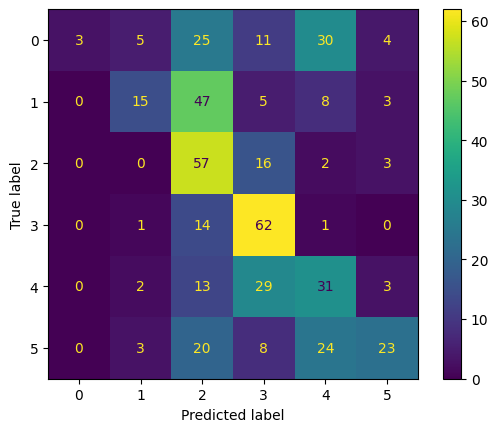

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(onnx_res["labels"], onnx_res["predictions"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

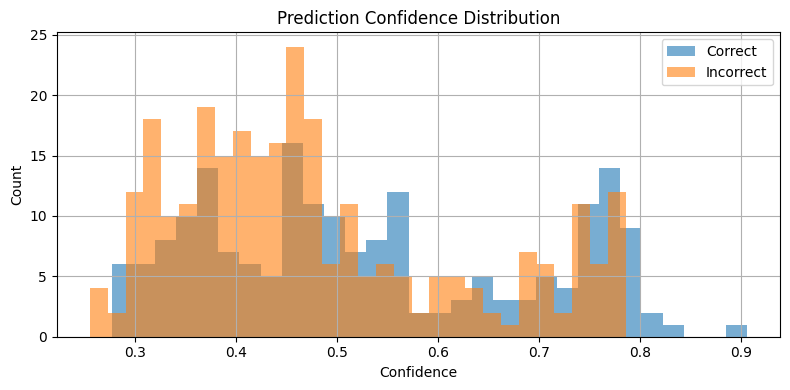

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(
    [c for c, correct in zip(onnx_res["probs"], onnx_res["correct_flags"]) if correct],
    bins=30, alpha=0.6, label="Correct"
)
plt.hist(
    [c for c, correct in zip(onnx_res["probs"], onnx_res["correct_flags"]) if not correct],
    bins=30, alpha=0.6, label="Incorrect"
)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Pytorch Model

Vérifier que:
- id in train/val/tests sont les mêmes pendant le training que dans le metadata
- les means et std sont les mêmes dans le training que metadata
- Bien vérifier qu'on a model.eval() a cause des dropouts
- Attention au data loader: DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
from utils.train import evaluate_pytorch_model

ckpt_path ="/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/ni0d4a07/checkpoints/last.ckpt"
metadata_path = '/cluster/home/kruu/git/eye_tracking/GazeMouse_Classification/ni0d4a07/model_metadata.json'
with open(metadata_path, "r") as f:
    metadata = json.load(f)

model_ckpt = LSTMClassifier.load_from_checkpoint(ckpt_path)
model_ckpt.eval()

res_train_pytorch = evaluate_pytorch_model(model_ckpt,
                                           dataset_time_resampled[dataset_time_resampled["id"].isin(metadata["test_ids"])],
                                           metadata["features"],
                                           metadata["mean"], 
                                           metadata["std"])

/raid/persistent_scratch/kruu/venvs/aware/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/cluster/home/kruu/git/eye_tracking/utils/dataset.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Relative timestamp'] = dataset.groupby('id')['Recording timestamp'].transform(lambda x: x - x.min())
/cluster/home/kruu/git/eye_tracking/utils/dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

🧠 PyTorch Evaluation: Loss = 2.8377, Accuracy = 0.2778


In [15]:
# def compare_model_weights(model_a, model_b):
#     for (name_a, param_a), (name_b, param_b) in zip(model_a.named_parameters(), model_b.named_parameters()):
#         if name_a != name_b:
#             print(f"❌ Name mismatch: {name_a} != {name_b}")
#             return
#         if not torch.allclose(param_a, param_b, atol=1e-6):
#             print(f"❌ Weight mismatch in layer: {name_a}")
#             return
#     print("✅ All weights match!")
    
# compare_model_weights(model, model_ckpt)

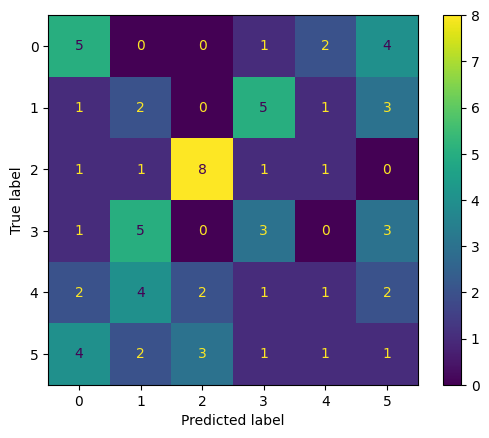

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(res_train_pytorch["labels"], res_train_pytorch["predictions"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

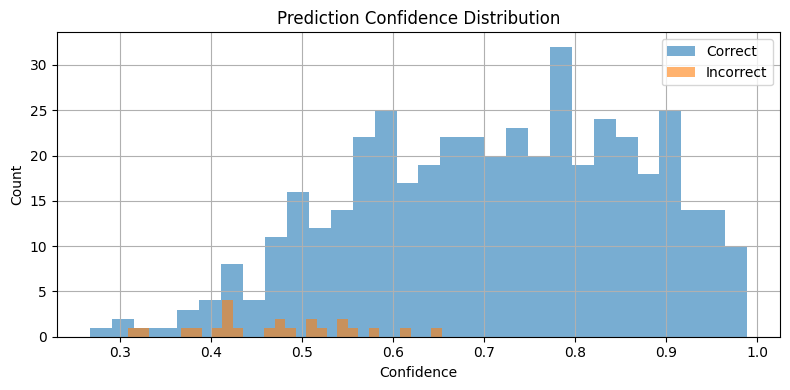

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(
    [c for c, correct in zip(res_train_pytorch["probs"], res_train_pytorch["correct_flags"]) if correct],
    bins=30, alpha=0.6, label="Correct"
)
plt.hist(
    [c for c, correct in zip(res_train_pytorch["probs"], res_train_pytorch["correct_flags"]) if not correct],
    bins=30, alpha=0.6, label="Incorrect"
)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ideas to reduce overfitting:
- Data augmentation
- Use label smoothing in focal loss
- Increase dropout
- Use TCN + LSTM  / use Joint Cross-Attention Fusion Network
- Add temperature scaling at inference
